In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/reed_uk.csv")

Overview of the dataset

In [3]:
df.head()

,category,city,company_name,geo,job_board,job_description,job_requirements,job_title,job_type,post_date,salary_offered,state
0,catering jobs,Chudleigh,Haulfryn Group,uk,reed,Apply now New opportunity not to be missed! H...,NaN,Commis Chef,"Permanent, full-time",3/12/2018,"£18,323 per annum",Devon
1,law jobs,Swindon,Reed,uk,reed,Apply now This role requires an experienced s...,NaN,Corporate Legal Secretary,"Permanent, full-time",3/8/2018,"£18,000 - £22,000 per annum",Wiltshire
2,factory jobs,Norfolk,Swanstaff Recruitment Ltd,uk,reed,Apply now Job Title: Warehouse personLocation...,NaN,Warehouse Person,"Permanent, full-time",2/27/2018,Salary not specified,East Anglia
3,law jobs,Hurstpierpoint,Castles Solicitors,uk,reed,Apply now Castles Solicitors are looking for ...,Required skills Admin Case Management Corresp...,Legal Secretary / Admin Assistant,"Permanent, full-time or part-time",2/21/2018,"£15,000 - £17,000 per annum, pro-rata",West Sussex
4,factory jobs,Hertfordshire,Marketplace Group,uk,reed,Apply now International Pharmaceutical Manufa...,NaN,Category Planner - Pharmaceutical,"Permanent, full-time",3/1/2018,"£37,000 - £45,000 per annum",South East England


In [4]:
print(f"The data has {df.shape[0]} registers")

The data has 50000 registers


Checking the number of unique values and missing values (NaN) for each variable (column)

In [5]:
df.nunique()

category               37
city                 2918
company_name         5166
geo                     1
job_board               1
job_description     42057
job_requirements    14887
job_title           29155
job_type                9
post_date              66
salary_offered       7345
state                 167
dtype: int64

In [6]:
#Missing values for each variable
df.isna().sum()

category                0
city                    0
company_name            0
geo                     0
job_board               0
job_description         0
job_requirements    29452
job_title               0
job_type                0
post_date               0
salary_offered          0
state                  20
dtype: int64

We can see that more than half of the data doesn't have the job_requirements value

Job type unique values

In [7]:
df.job_type.unique()

array(['Permanent, full-time', 'Permanent, full-time or part-time',
       'Permanent, part-time', 'Contract, full-time',
       'Temporary, part-time', 'Temporary, full-time or part-time',
       'Temporary, full-time', 'Contract, full-time or part-time',
       'Contract, part-time'], dtype=object)

In [8]:
df.category.unique()

array(['catering jobs', 'law jobs', 'factory jobs', 'retail jobs',
       'motoring automotive jobs', 'hr jobs', 'marketing jobs',
       'estate agent jobs', 'customer service jobs',
       'accountancy qualified jobs', 'health jobs', 'logistics jobs',
       'finance jobs', 'social care jobs', 'recruitment consultancy jobs',
       'construction property jobs', 'engineering jobs',
       'admin secretarial pa jobs', 'accountancy jobs', 'sales jobs',
       'it jobs', 'education jobs', 'other jobs', 'security safety jobs',
       'energy jobs', 'apprenticeships jobs', 'training jobs',
       'charity jobs', 'strategy consultancy jobs', 'banking jobs',
       'purchasing jobs', 'fmcg jobs', 'leisure tourism jobs',
       'science jobs', 'graduate training internships jobs',
       'general insurance jobs', 'media digital creative jobs'],
      dtype=object)

Salary_offered variable analysis 

In [9]:
#Number of offers without the £ symbol
(~df.salary_offered.str.contains("£")).sum()

9031

In [10]:
#Unique values and their count in the offers without the £ symbol
df[~df.salary_offered.str.contains("£")].salary_offered.value_counts()

 Salary negotiable                                  4539
 Competitive salary                                 3998
 Salary not specified                                317
 Commission only                                      29
 ‚¬45,000 - ‚¬55,000 per annum                         7
                                                    ... 
 up to ‚¬39.00 per hour                                1
 ‚¬51,549 per annum                                    1
 ‚¬60,000 - ‚¬70,000 per annum, negotiable, OTE        1
 ‚¬11.40 per hour                                      1
 ‚¬25,000 - ‚¬26,600 per annum                         1
Name: salary_offered, Length: 103, dtype: int64

We can see that most of the job offers without the £ symbol in the salary corresponds to offers that doesn't publish the value of the salary (8883 out of 9031) instead they publish some generic text like Salary negotiable, Competitive salary, Salary not specified or Commission only. The remaining 148 offers in this group use a different currency.
So we proceed to discard the offers without the £ symbol in the salary.

In [11]:
df2 = df[df.salary_offered.str.contains("£")].reset_index(drop=True).copy()

In [12]:
len(df2)

40969

40969 offers remaining

In [13]:
#Unique values and their count in the salary of the remaining offers 
df2.salary_offered.value_counts()

 £30,000 - £35,000 per annum                        633
 £25,000 - £30,000 per annum                        569
 £35,000 - £40,000 per annum                        488
 £20,000 - £25,000 per annum                        487
 £7.50 per hour                                     477
                                                   ... 
 £9,750 per annum, inc benefits                       1
 £43,807 - £48,265 per annum, pro-rata                1
 £41,502 - £44,454 per annum                          1
 £18,000 - £21,500 per annum, inc benefits, OTE       1
 £44,000 - £59,000 per annum                          1
Name: salary_offered, Length: 7242, dtype: int64

We want to get a unique value of the salary for each offer (those values must be comparable), but we found that some of the offers have a range of values and the periodicity of the salaries varies across the offers (annum, day, hour).

Next we are going to process the salary variable to obtain a single annum value for each offer

In [14]:
#Every offer contains the word per, this is key
df2.salary_offered.str.contains("per").sum()

40969

In [15]:
#df2.salary_offered.str.extract(r"(per.*)")[0].value_counts()

In [16]:
#Splitting the original salary variable into min_salary, max_salary and periodicity
salary_processing_df = df2.salary_offered.str.extract(
    r"(?P<min_salary>£.*)?(?P<max_salary>£.*)(?P<per>per )(?P<periodicity>annum|day|hour)"
).drop(columns=["per"])

In [17]:
#Converting from str to numerical
salary_processing_df["min_salary"] = salary_processing_df["min_salary"].str.extract(r"([0-9][0-9,\.]*)", expand=False).str.replace(',', '').astype(float)
salary_processing_df["max_salary"] = salary_processing_df["max_salary"].str.extract(r"([0-9][0-9,\.]*)", expand=False).str.replace(',', '').astype(float)

In [19]:
#Calculating the annum avg salary
#sources 
#working hours: https://clockify.me/working-hours
#working days: https://hello-safe.co.uk/business-insurance/tools/working-days-calculator#:~:text=How%20many%20days%20are%20in,256%20working%20days
uk_working_days = 256
uk_working_hours = 1670

def get_annum_avg_salary(row):
    avg_salary = np.nanmean(np.array([row["min_salary"], row["max_salary"]]))
    if row["periodicity"] == "day":
        avg_salary *= uk_working_days
    if row["periodicity"] == "hour":
        avg_salary *= uk_working_hours
    return avg_salary

salary_processing_df["annum_avg_salary"] = salary_processing_df.apply(get_annum_avg_salary, axis=1)

In [20]:
#mergin the new values calculated and the original data
df2 = pd.concat([df2, salary_processing_df], axis=1)
df2.head()

,category,city,company_name,geo,job_board,job_description,job_requirements,job_title,job_type,post_date,salary_offered,state,min_salary,max_salary,periodicity,annum_avg_salary
0,catering jobs,Chudleigh,Haulfryn Group,uk,reed,Apply now New opportunity not to be missed! H...,NaN,Commis Chef,"Permanent, full-time",3/12/2018,"£18,323 per annum",Devon,NaN,18323.0,annum,18323.0
1,law jobs,Swindon,Reed,uk,reed,Apply now This role requires an experienced s...,NaN,Corporate Legal Secretary,"Permanent, full-time",3/8/2018,"£18,000 - £22,000 per annum",Wiltshire,18000.0,22000.0,annum,20000.0
2,law jobs,Hurstpierpoint,Castles Solicitors,uk,reed,Apply now Castles Solicitors are looking for ...,Required skills Admin Case Management Corresp...,Legal Secretary / Admin Assistant,"Permanent, full-time or part-time",2/21/2018,"£15,000 - £17,000 per annum, pro-rata",West Sussex,15000.0,17000.0,annum,16000.0
3,factory jobs,Hertfordshire,Marketplace Group,uk,reed,Apply now International Pharmaceutical Manufa...,NaN,Category Planner - Pharmaceutical,"Permanent, full-time",3/1/2018,"£37,000 - £45,000 per annum",South East England,37000.0,45000.0,annum,41000.0
4,retail jobs,Belfast,Vodafone,uk,reed,Apply on employer's website Retail Advisor - ...,NaN,Retail Adviser 20hrs/week - Belfast Donnegal P...,"Permanent, part-time",3/12/2018,"£9,100 - £9,152 per annum, OTE",County Antrim,9100.0,9152.0,annum,9126.0


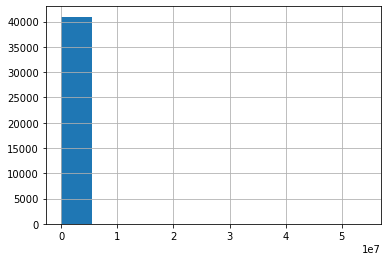

In [22]:
#Plotting the histogram of the annum average salary
df2.annum_avg_salary.hist()

In [23]:
df2.annum_avg_salary.describe().apply(lambda x: format(x, 'f'))

count       40969.000000
mean        40014.862042
std        614380.483834
min             0.000000
25%         19500.000000
50%         27000.000000
75%         37500.000000
max      54275000.000000
Name: annum_avg_salary, dtype: object

There are really huge values that seem wrong. This suggests some inconsistency in the data that we are going to verify next.

In [37]:
pd.reset_option('display.max_colwidth')

In [38]:
df2[df2.annum_avg_salary > 200000].sort_values("annum_avg_salary")

,category,city,company_name,geo,job_board,job_description,job_requirements,job_title,job_type,post_date,salary_offered,state,min_salary,max_salary,periodicity,annum_avg_salary
17380,strategy consultancy jobs,South West England,Execuitve Resource Group,uk,reed,Apply now Director - Finance - Procurement - ...,Required skills Director of Finance and Procu...,Director of Finance and Procurement,"Contract, full-time",3/9/2018,£750.00 - £825.00 per day,England,750.0,825.0,day,201600.0
39245,strategy consultancy jobs,South West England,Execuitve Resource Group,uk,reed,Apply now Director - Finance - Procurement - ...,Required skills Director of Finance and Procu...,Director of Finance and Procurement,"Contract, full-time",3/9/2018,£750.00 - £825.00 per day,England,750.0,825.0,day,201600.0
37996,strategy consultancy jobs,South West England,Execuitve Resource Group,uk,reed,Apply now Director - Finance - Procurement - ...,Required skills Director of Finance and Procu...,Director of Finance and Procurement,"Contract, full-time",3/9/2018,£750.00 - £825.00 per day,England,750.0,825.0,day,201600.0
14167,it jobs,City of London,SmartTasking.com,uk,reed,Apply now IT Program Director | Central Londo...,Required skills Portfolio Management Program ...,IT Program Director,"Contract, full-time",3/12/2018,£750.00 - £850.00 per day,London,750.0,850.0,day,204800.0
17277,banking jobs,City Of London,Eames Consulting Group,uk,reed,Apply now Senior Quantitative Analyst - Equit...,Required skills C++ FX Options developer fron...,Senior Quantitiave Analyst - Equity and model ...,"Contract, full-time",2/23/2018,"£600.00 - £1,000.00 per day",London,600.0,1000.0,day,204800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23679,hr jobs,Tunbridge Wells,Reed Human Resources,uk,reed,Apply now ** Recruitment Advisors Wanted **Re...,NaN,Resourcing Advisor,"Temporary, full-time",3/6/2018,"£23,000.00 - £32,000.00 per hour",Kent,23000.0,32000.0,hour,45925000.0
21806,hr jobs,Maidstone,Reed Human Resources,uk,reed,Apply now ** Recruitment Advisors Wanted **Re...,NaN,Resourcing Advisor,"Temporary, full-time",3/6/2018,"£23,000.00 - £32,000.00 per hour",Kent,23000.0,32000.0,hour,45925000.0
15214,education jobs,Bradford,Reed Education,uk,reed,Apply now As a Key Stage 2 class teacher you ...,NaN,Primary School Teacher,"Temporary, full-time",3/8/2018,"£22,000.00 - £38,000.00 per hour",West Yorkshire,22000.0,38000.0,hour,50100000.0
14867,education jobs,Bradford,Reed Education,uk,reed,Apply now Key Stage 1 Class Teacher required ...,NaN,Key Stage One Class Teacher | September 2018 |,"Temporary, full-time",3/8/2018,"£22,000.00 - £38,000.00 per hour",West Yorkshire,22000.0,38000.0,hour,50100000.0


In [189]:
#TODOS
#Check for errors in salary variable and clean the data

0

In [226]:
df2[df2.annum_avg_salary > 200000]

,category,city,company_name,geo,job_board,job_description,job_requirements,job_title,job_type,post_date,salary_offered,state,min_salary,max_salary,periodicity,annum_avg_salary
1020,hr jobs,West Midlands,Gleeson Recruitment Group,uk,reed,Apply now Gleeson HR are currently recruiting...,NaN,Head of HR,"Permanent, full-time",3/8/2018,"£60,000 - £650,000 per annum",West Midlands (Region),60000.0,650000.0,annum,355000.0
1263,retail jobs,Taunton,McCarthy Recruitment Ltd,uk,reed,Apply now Job Title:Retail Store ManagerLocat...,NaN,Store Manager,"Permanent, full-time",3/12/2018,"£408,000 - £447,600 per annum",Somerset,408000.0,447600.0,annum,427800.0
1438,law jobs,Boston,Taskmaster,uk,reed,Apply now We are looking for a Private Client...,Required skills solicitor,Private Client Solicitor in Boston,"Permanent, full-time",3/8/2018,"£35,000 - £400,000 per annum",Lincolnshire,35000.0,400000.0,annum,217500.0
2245,law jobs,London,Ryder Reid Legal Ltd,uk,reed,Apply now Our client is a prestigious US law ...,NaN,P/A Legal Secretary in Private Equity/Funds to...,"Permanent, full-time",3/12/2018,"£45,000 - £450,000 per annum",South East England,45000.0,450000.0,annum,247500.0
3379,retail jobs,Walton On The Naze,McCarthy Recruitment Ltd,uk,reed,Apply now Job Title: Retail Store Manager/Ret...,NaN,Assistant Store Manager/Store Manager,"Permanent, full-time",2/26/2018,"£375,600 - £701,400 per annum",Essex,375600.0,701400.0,annum,538500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39060,banking jobs,Central London,Eames Consulting Group,uk,reed,"Apply now A well-known, multinational investm...",Required skills C# C++ Equity Derivatives Equ...,Equities Price and Model Validation,"Contract, full-time",3/9/2018,£750.00 - £900.00 per day,London,750.0,900.0,day,211200.0
39203,banking jobs,London,Orleans House,uk,reed,Apply now We are searching for an experienced...,NaN,Capital Markets Consultant,"Contract, full-time",3/8/2018,"£800.00 - £1,200.00 per day",South East England,800.0,1200.0,day,256000.0
39245,strategy consultancy jobs,South West England,Execuitve Resource Group,uk,reed,Apply now Director - Finance - Procurement - ...,Required skills Director of Finance and Procu...,Director of Finance and Procurement,"Contract, full-time",3/9/2018,£750.00 - £825.00 per day,England,750.0,825.0,day,201600.0
39477,banking jobs,City Of London,Marks Sattin (UK) Ltd,uk,reed,Apply now Head of Finance I am working with a...,NaN,Head of Finance,"Permanent, full-time",3/8/2018,"£80,000 - £900,000 per annum",London,80000.0,900000.0,annum,490000.0


Job description variable EDA

In [40]:
import nltk
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 
from string import punctuation
import collections

General information about the length of the job descriptions

In [60]:
description_lengths = df2.job_description.apply(lambda x: len(nltk.word_tokenize(x)))

In [61]:
description_lengths.describe()

count    40969.000000
mean       312.082721
std        153.847203
min         17.000000
25%        203.000000
50%        287.000000
75%        391.000000
max       1125.000000
Name: job_description, dtype: float64

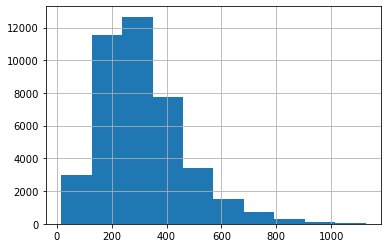

In [62]:
review_words_lengths.hist()

Text cleaning

In [83]:
from nltk.corpus import stopwords
nltk.download('wordnet')
stop_words = set(stopwords.words('english')) 

def text_to_clean_words(text):
    text = text.lower()
    # Removing numbers, *** and www links from the data
    text = re.sub('[0-9]+\s+|\s\d+\s|\w+[0-9]+|www\.[^\s]+','',text)
    # Removing punctuation
    for p in punctuation:
        text = text.replace(p,'')
    word_tokens = nltk.word_tokenize(text)

    ## Removing the stopwords
    words_clean = [each for each in word_tokens if each not in stop_words and len(each) > 2]
    return words_clean

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [84]:
clean_job_description_tokens = df2.iloc[:,:].job_description.apply(text_to_clean_words)

In [85]:
l = list(clean_job_description_tokens)
l1 = [item for sublist in l for item in sublist]

top words

In [86]:
word_freq_lem = dict(collections.Counter(l1))
keys = list(word_freq_lem.keys())
values = list(word_freq_lem.values())
df_lem = pd.DataFrame({'words':keys,'freq':values})
display(df_lem.sort_values(by = 'freq',ascending = False)[10:20])


,words,freq
213,client,33698
47,skills,33272
76,service,31409
326,support,30950
515,company,29960
168,management,29522
572,please,29210
829,sales,28840
1,new,28417
339,customer,26401


In [79]:
df3 = df2[df2.annum_avg_salary > df2.annum_avg_salary.quantile(0.80)]

In [82]:
clean_job_description_tokens = df3.iloc[:,:].job_description.apply(text_to_clean_words)
l = list(clean_job_description_tokens)
l1 = [item for sublist in l for item in sublist]
word_freq_lem = dict(collections.Counter(l1))
keys = list(word_freq_lem.keys())
values = list(word_freq_lem.values())
df_lem = pd.DataFrame({'words':keys,'freq':values})
display(df_lem.sort_values(by = 'freq',ascending = False)[10:20])

,words,freq
702,client,7596
499,manager,7476
182,new,6777
206,skills,6405
244,looking,6347
124,development,6320
338,please,5639
501,company,5343
1060,opportunity,5341
809,sales,5110


In [228]:
df2.to_csv("data/reed_uk_v2.csv", index=False)